# Permutation Feature Importance (PFI) for Geotechnical ML

This notebook demonstrates model-agnostic permutation feature importance (PFI) to identify influential features for a classification model in a geotechnical context.

Learning goals:
- Understand the idea behind permutation importance
- Train a Random Forest classifier on a small, CPT-like synthetic dataset
- Compute and visualize permutation importances on a held-out test set
- Compare PFI to model-based (impurity) feature importances
- Discuss pitfalls (especially correlated features)

Optional: You can also explore your local CPT dataset at `data/raw/CPT_PremstallerGeotechnik_revised.csv` if it includes labels.

## Theory (brief)

Permutation Feature Importance is a model-agnostic technique that measures how much a model
relies on a given feature. For a trained model, we:
1. Compute a baseline score on a validation/test set (e.g., accuracy).
2. For each feature, randomly shuffle its values across samples (breaking its association with the target).
3. Recompute the score. The drop in performance indicates the feature's importance.

Key properties:
- Model-agnostic: works with any predictive model as long as you can score it.
- Evaluated on held-out data: importance reflects generalization.
- Sensitive to correlation: if two features are correlated, shuffling one may not degrade performance much because the other still carries similar information.

In [1]:
# Imports and configuration
from __future__ import annotations

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

RNG_SEED = 42
np.random.seed(RNG_SEED)
sns.set_theme(style="whitegrid", context="notebook")

# For reproducible figures in notebooks
%config InlineBackend.figure_format = 'retina'

## Create a small CPT-like synthetic dataset

We simulate a few common CPT-related features:
- depth [m]
- qc: cone tip resistance [MPa]
- fs: sleeve friction [MPa]
- Fr: friction ratio [%] = 100 * fs / qc
- Rf: a lightly perturbed copy of Fr (to introduce correlation)

We then generate soil classes using simple thresholds on Fr and qc. This is for teaching only—
not a rigorous geotechnical classification.

In [2]:
# Generate synthetic CPT-like data
n = 1500
depth = np.sort(np.random.uniform(0.0, 30.0, size=n))
qc = np.clip(np.random.lognormal(mean=1.5, sigma=0.6, size=n), 0.2, None)  # MPa-ish
fs = np.clip(
    np.random.lognormal(mean=0.0, sigma=0.5, size=n) * 0.1, 0.002, None
)  # MPa-ish
Fr = 100.0 * fs / np.clip(qc, 1e-6, None)
Rf = Fr + np.random.normal(0.0, 0.2, size=n)  # correlated with Fr

# Add some extra weakly informative noise features
noise1 = np.random.normal(0.0, 1.0, size=n)
noise2 = np.random.uniform(-1.0, 1.0, size=n)

# Define a simple soil class (3 classes) based on qc and Fr
# Class 0: high qc, low Fr (e.g., sands)
# Class 1: medium qc, medium Fr (e.g., silts)
# Class 2: low qc, high Fr (e.g., clays)
labels = np.where((qc > 8.0) & (Fr < 1.5), 0, np.where((qc < 3.0) & (Fr > 2.5), 2, 1))

df = pd.DataFrame(
    {
        "depth": depth,
        "qc": qc,
        "fs": fs,
        "Fr": Fr,
        "Rf": Rf,
        "noise1": noise1,
        "noise2": noise2,
        "soil_class": labels,
    }
)

df.head()

,depth,qc,fs,Fr,Rf,noise1,noise2,soil_class
0,0.138961,1.000357,0.055555,5.553516,5.556082,-0.054778,-0.201919,2
1,0.148199,17.717725,0.063920,0.360770,0.456735,-0.922413,0.959829,0
2,0.151848,1.946935,0.134799,6.923647,6.869918,0.007363,-0.548237,2
3,0.165664,1.669895,0.062240,3.727174,3.359902,-1.478547,0.224317,2
4,0.172760,8.277511,0.126062,1.522945,1.436390,-0.487633,-0.134054,1


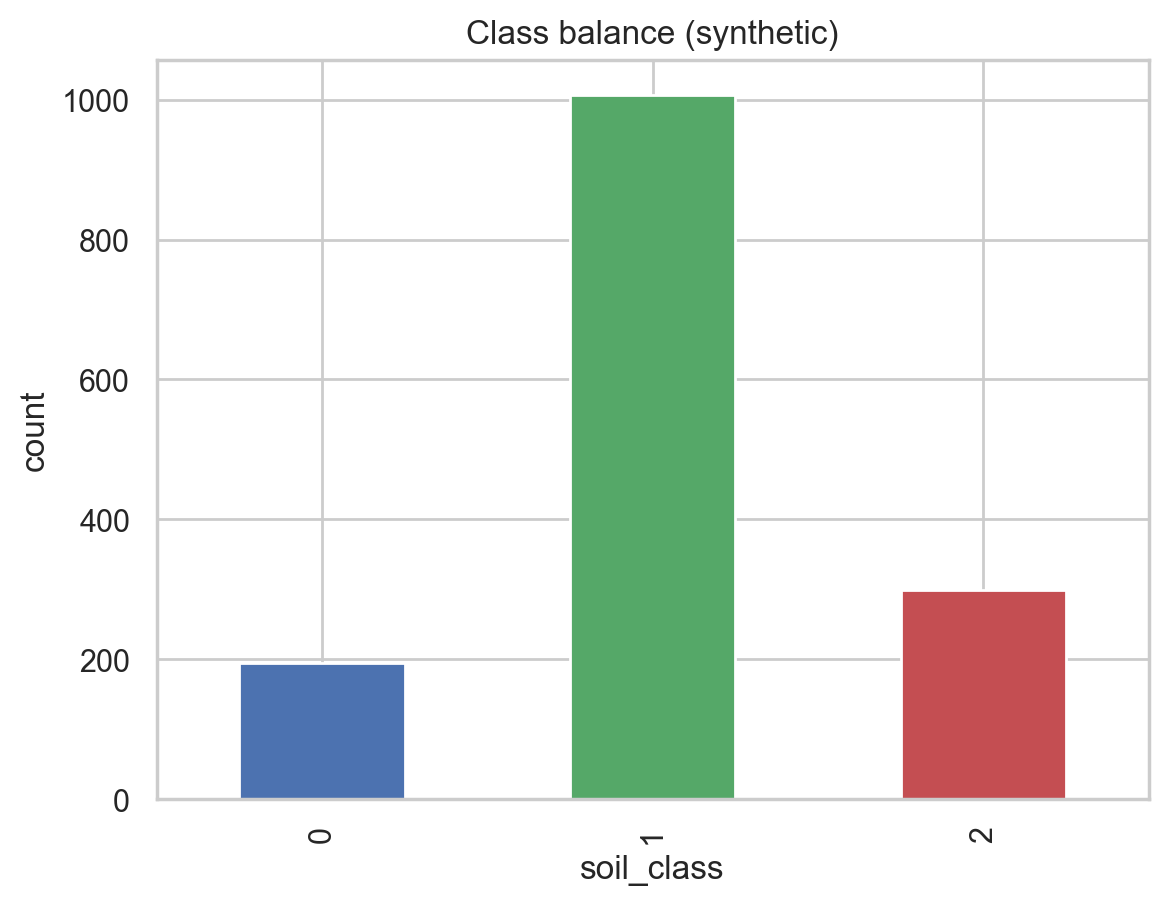

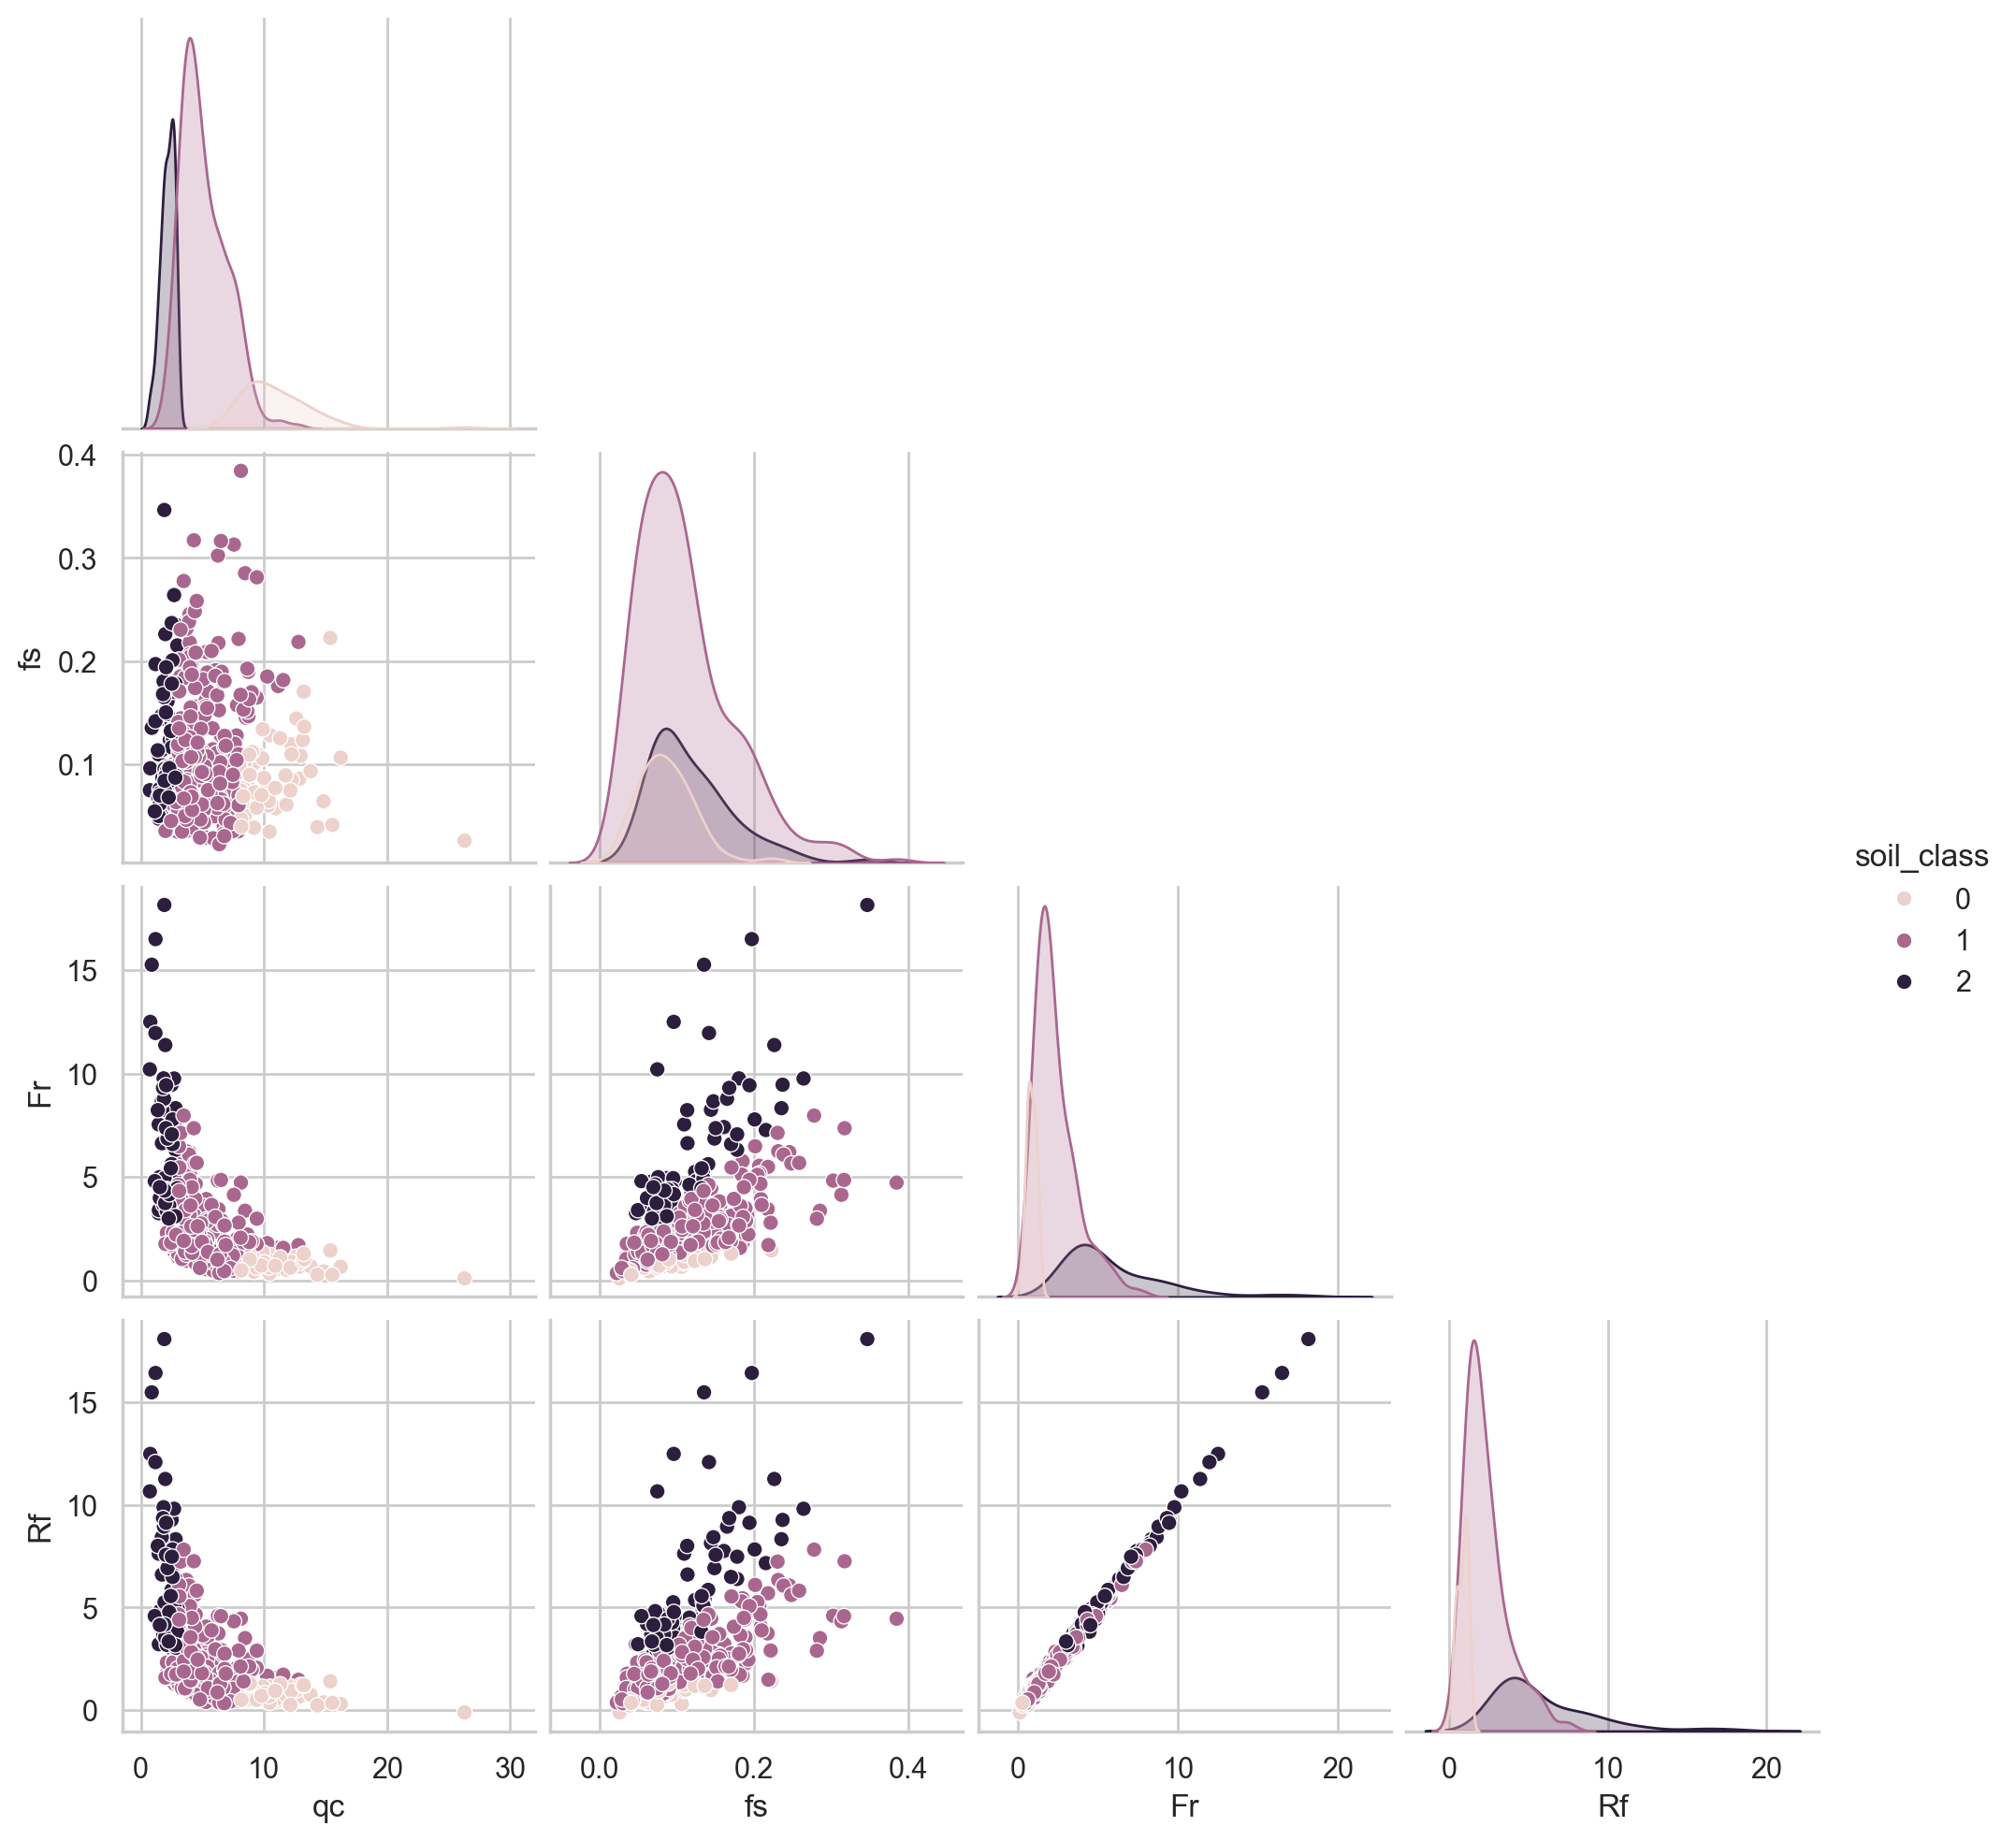

In [3]:
# Quick EDA: class balance and feature distributions
ax = (
    df["soil_class"]
    .value_counts()
    .sort_index()
    .plot(kind="bar", color=["#4C72B0", "#55A868", "#C44E52"])
)
ax.set_xlabel("soil_class")
ax.set_ylabel("count")
ax.set_title("Class balance (synthetic)")
plt.show()

sns.pairplot(
    df.sample(400, random_state=RNG_SEED),
    vars=["qc", "fs", "Fr", "Rf"],
    hue="soil_class",
    corner=True,
)
plt.show()

## Train/test split and Random Forest training

We keep the code flat (no helper functions) for clarity while teaching.

Test accuracy: 0.997

Classification report:
               precision    recall  f1-score   support

           0      1.000     1.000     1.000        49
           1      0.996     1.000     0.998       251
           2      1.000     0.987     0.993        75

    accuracy                          0.997       375
   macro avg      0.999     0.996     0.997       375
weighted avg      0.997     0.997     0.997       375



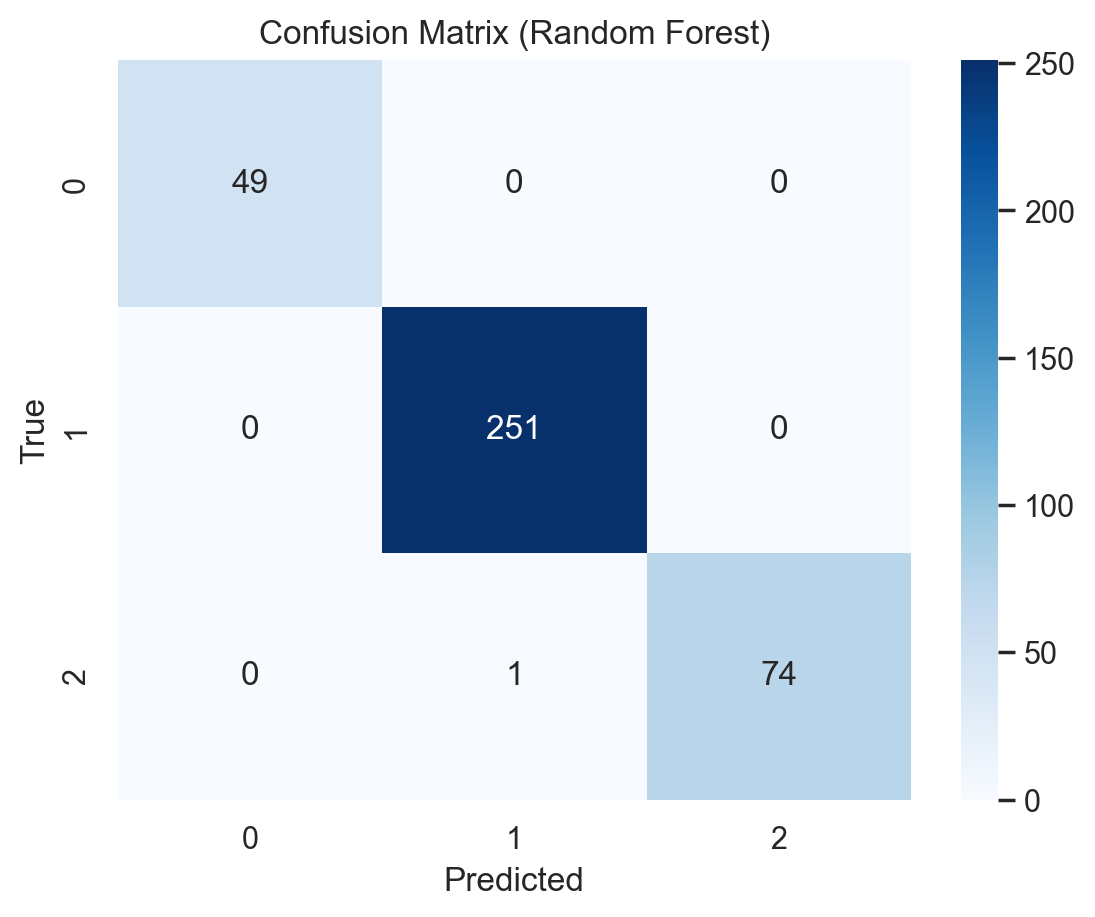

In [4]:
feature_names = ["depth", "qc", "fs", "Fr", "Rf", "noise1", "noise2"]
X = df[feature_names].copy()
y = df["soil_class"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RNG_SEED, stratify=y
)

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=RNG_SEED,
    n_jobs=-1,
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc:.3f}")
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Random Forest)")
plt.show()

## Model-based importances (impurity)

These are the built-in feature importances from the Random Forest (based on impurity reduction).
They can be biased toward features with more unique values. We'll compare them to permutation importances next.

C:\Users\TFH\AppData\Local\Temp\ipykernel_20584\2398201094.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=imp.values, y=imp.index, palette="viridis")


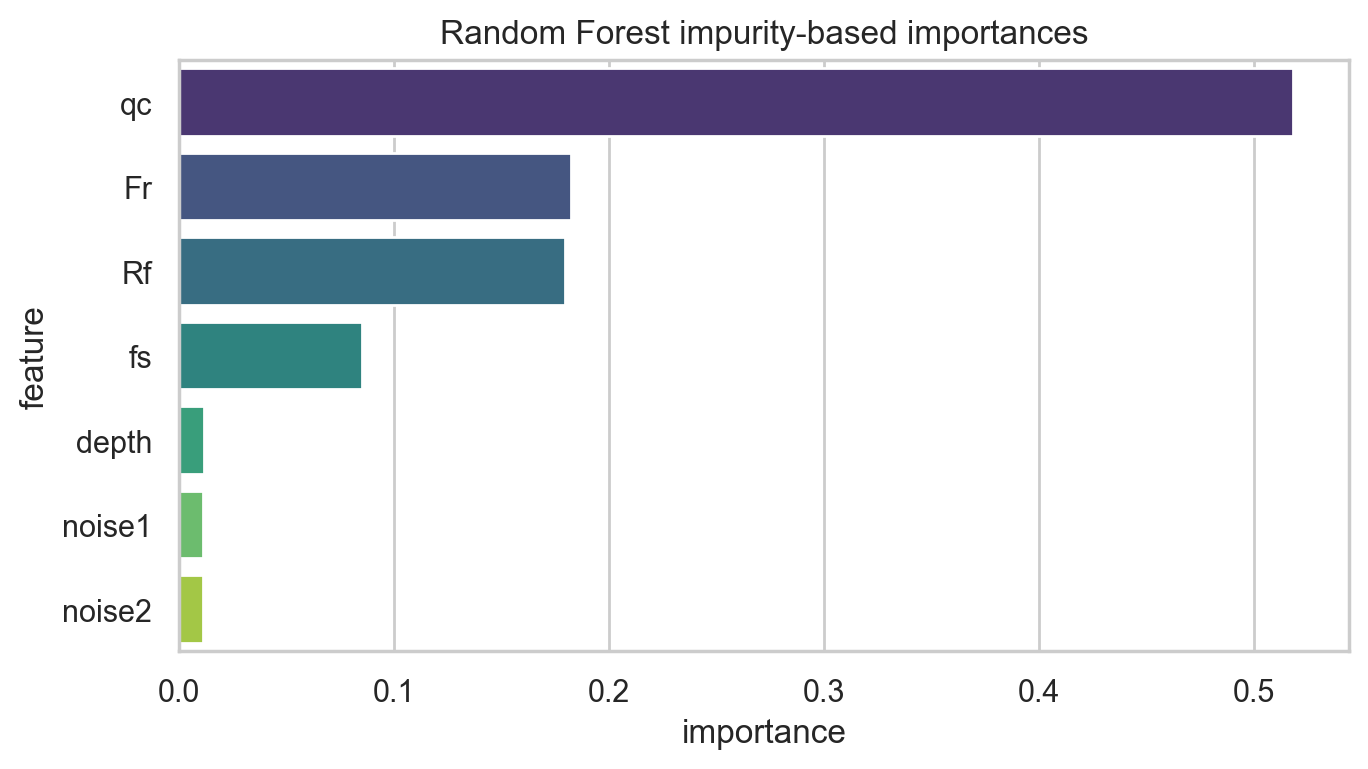

qc        0.518295
Fr        0.182638
Rf        0.179728
fs        0.085131
depth     0.011578
noise1    0.011471
noise2    0.011160
dtype: float64

In [5]:
imp = pd.Series(rf.feature_importances_, index=feature_names).sort_values(
    ascending=False
)
plt.figure(figsize=(7, 4))
sns.barplot(x=imp.values, y=imp.index, palette="viridis")
plt.title("Random Forest impurity-based importances")
plt.xlabel("importance")
plt.ylabel("feature")
plt.tight_layout()
plt.show()
imp

## Permutation Feature Importance (PFI)

We estimate PFI on the test set to reflect generalization. We repeat permutations to capture variance.

In [6]:
result = permutation_importance(
    rf, X_test, y_test, n_repeats=25, random_state=RNG_SEED, scoring="accuracy"
)

pfi_df = pd.DataFrame(
    {
        "feature": feature_names,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }
).sort_values("importance_mean", ascending=False)
pfi_df

,feature,importance_mean,importance_std
1,qc,0.344533,0.014469
3,Fr,0.065493,0.008766
4,Rf,0.028907,0.007643
2,fs,0.000960,0.002117
6,noise2,0.000533,0.001067
5,noise1,0.000320,0.000867
0,depth,0.000213,0.000723


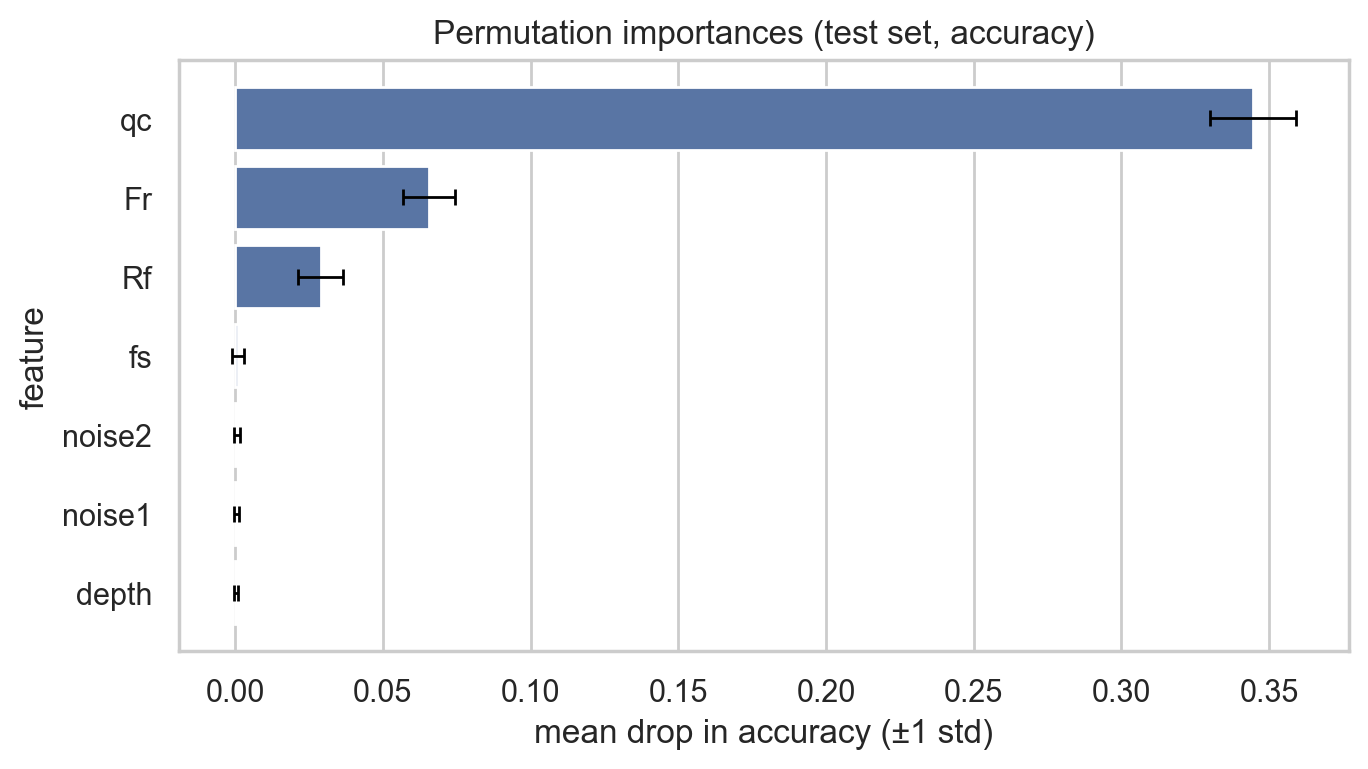

In [7]:
plt.figure(figsize=(7, 4))
# Draw bars without seaborn's built-in errorbars to avoid shape mismatch during color scouting
ax = sns.barplot(
    data=pfi_df,
    x="importance_mean",
    y="feature",
    errorbar=None,  # disable seaborn error bars
    color="#4C72B0",
)

# Add manual horizontal error bars centered on each bar
for i, (mean, std) in enumerate(
    zip(pfi_df["importance_mean"], pfi_df["importance_std"], strict=False)
):
    bar = ax.patches[i]
    y = bar.get_y() + bar.get_height() / 2
    ax.errorbar(
        mean,
        y,
        xerr=std,
        fmt="none",
        ecolor="black",
        elinewidth=1,
        capsize=3,
    )

plt.title("Permutation importances (test set, accuracy)")
plt.xlabel("mean drop in accuracy (±1 std)")
plt.ylabel("feature")
plt.tight_layout()
plt.show()

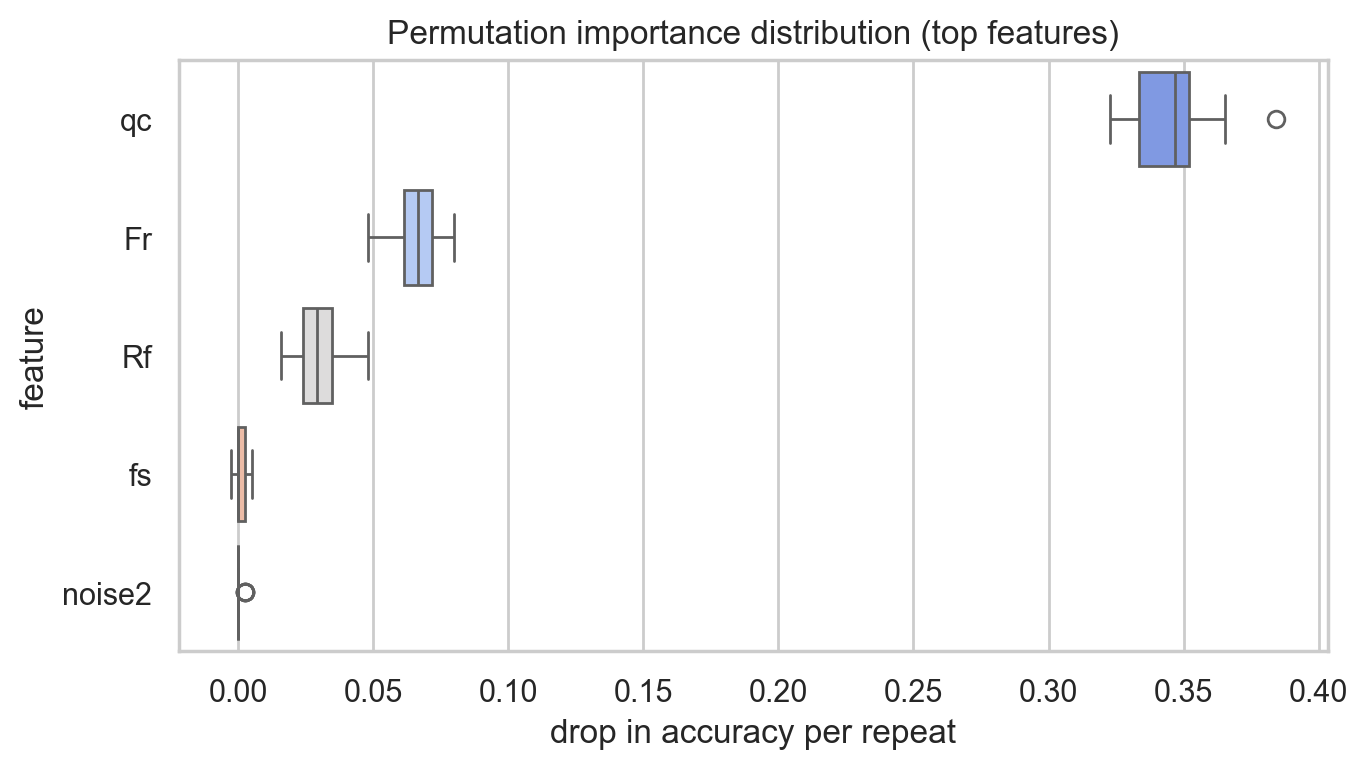

In [8]:
# Optional: show distribution across repeats for top few features (robust to orientation)
top_feats = pfi_df["feature"].head(5).tolist()
arr = result.importances  # typically (n_repeats, n_features)

if arr.ndim != 2:
    raise ValueError("Unexpected shape for result.importances; expected 2D array.")

if arr.shape[1] == len(feature_names):
    # Expected shape
    imp_m = pd.DataFrame(arr, columns=feature_names)[top_feats]
elif arr.shape[0] == len(feature_names):
    # Transposed shape
    imp_m = pd.DataFrame(arr.T, columns=feature_names)[top_feats]
else:
    # Fallback: construct and intersect with available columns
    cols = feature_names[: arr.shape[1]]
    imp_m = pd.DataFrame(arr, columns=cols)
    avail = [f for f in top_feats if f in imp_m.columns]
    imp_m = imp_m[avail]

plt.figure(figsize=(7, 4))
sns.boxplot(data=imp_m, orient="h", palette="coolwarm")
plt.title("Permutation importance distribution (top features)")
plt.xlabel("drop in accuracy per repeat")
plt.ylabel("feature")
plt.tight_layout()
plt.show()

  feature  impurity       pfi
1      qc  0.518295  0.344533
3      Fr  0.182638  0.065493
4      Rf  0.179728  0.028907
2      fs  0.085131  0.000960
6  noise2  0.011160  0.000533
5  noise1  0.011471  0.000320
0   depth  0.011578  0.000213


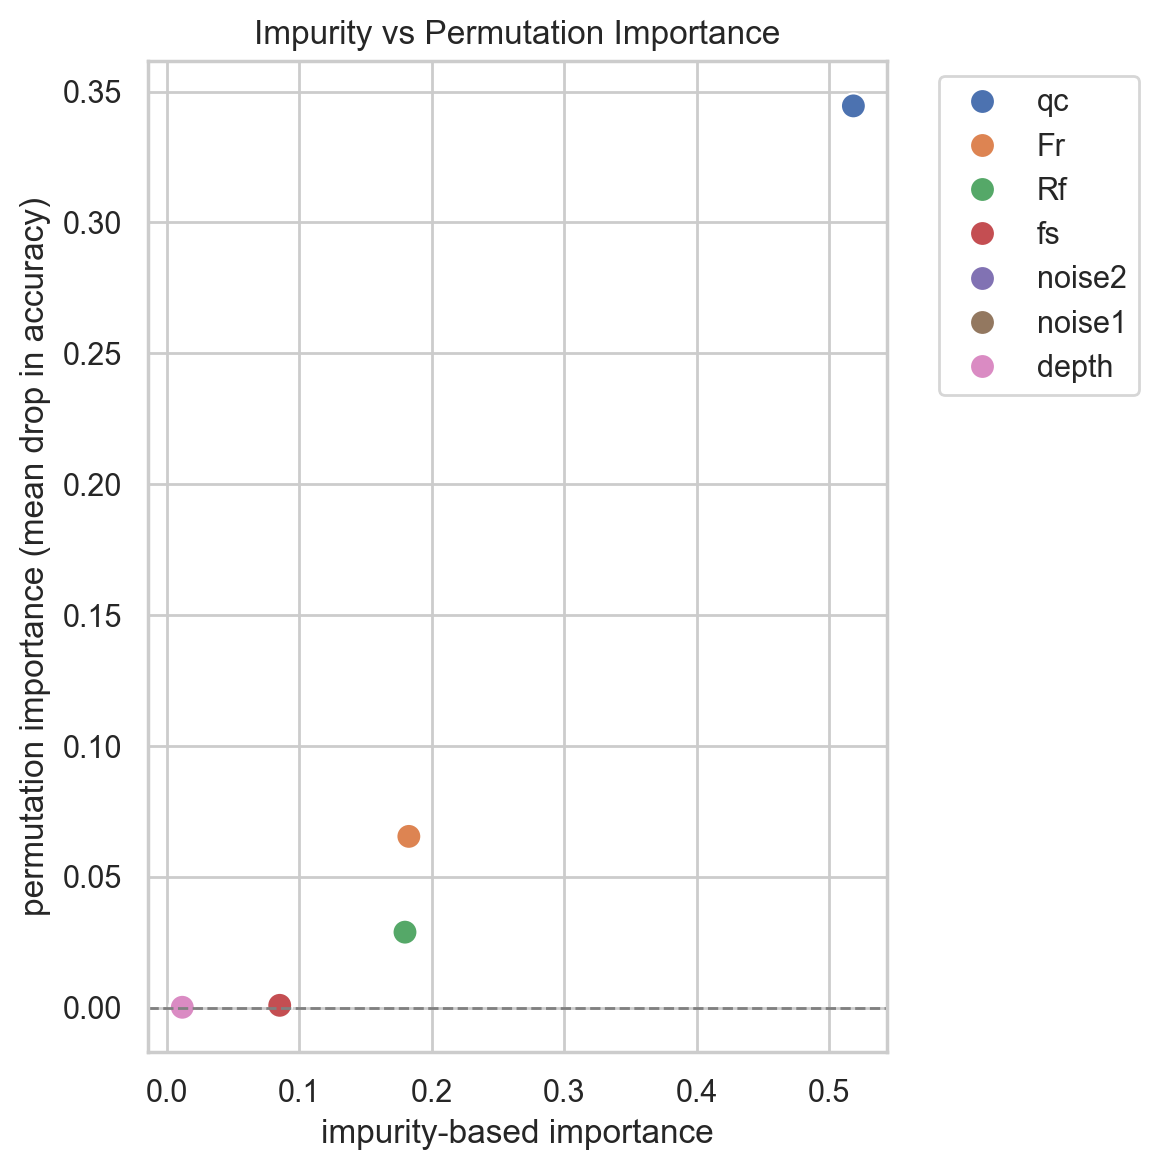

In [9]:
compare_df = pd.DataFrame(
    {
        "feature": feature_names,
        "impurity": imp.reindex(feature_names).values,
        "pfi": pfi_df.set_index("feature")
        .reindex(feature_names)["importance_mean"]
        .values,
    }
).sort_values("pfi", ascending=False)
print(compare_df)

plt.figure(figsize=(6, 6))
sns.scatterplot(data=compare_df, x="impurity", y="pfi", hue="feature", s=80)
plt.axhline(0, color="gray", lw=1, ls="--")
plt.title("Impurity vs Permutation Importance")
plt.xlabel("impurity-based importance")
plt.ylabel("permutation importance (mean drop in accuracy)")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")
plt.tight_layout()
plt.show()

## Explore curated CPT dataset (model_ready/cpt_dataset_total.csv)

Use the curated, preprocessed CPT dataset stored at `data/model_ready/cpt_dataset_total.csv`. It includes standard CPT features and the label `Oberhollenzer_classes` (1–7).

The cell below will:
- load the curated dataset (no availability checks)
- select the 9 supervised features listed for this course
- define X (features) and y (labels)
- apply minimal NaN/Inf handling for safety
- train a Random Forest on a train/test split
- compute and visualize permutation importances

Curated CPT — Test accuracy: 0.828

Classification report:
               precision    recall  f1-score   support

         0.0      0.750     0.744     0.747     15120
         1.0      0.782     0.761     0.771     22420
         2.0      0.759     0.760     0.759      8560
         3.0      0.812     0.685     0.744      1081
         4.0      0.818     0.780     0.798     23555
         5.0      0.832     0.869     0.850     50650
         6.0      0.833     0.836     0.834     42111
         7.0      0.899     0.889     0.894     38327

    accuracy                          0.828    201824
   macro avg      0.811     0.790     0.800    201824
weighted avg      0.828     0.828     0.828    201824



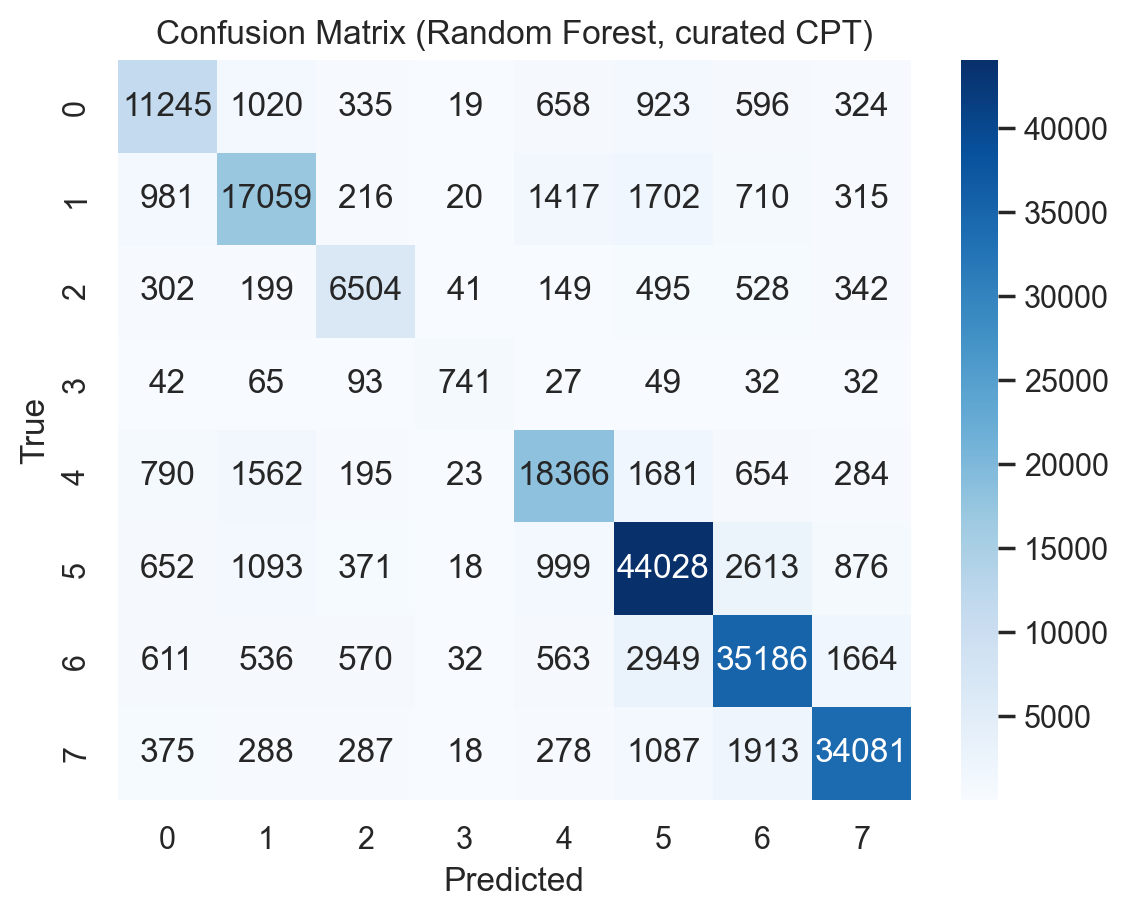

KeyboardInterrupt: 

In [ ]:
from pathlib import Path

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Load curated dataset (supervised)
DATA_DIR = Path("..") / "data" / "model_ready"
CSV = DATA_DIR / "cpt_dataset_total.csv"

FEATURES = [
    "Depth (m)",
    "qc (MPa)",
    "fs (kPa)",
    "Rf (%)",
    "σ,v (kPa)",
    "u0 (kPa)",
    "σ',v (kPa)",
    "Qtn (-)",
    "Fr (%)",
]
LABEL = "Oberhollenzer_classes"

# Read and prepare
curated_df = pd.read_csv(CSV)
X = curated_df[FEATURES].copy()
y = curated_df[LABEL].copy()

# Basic cleaning: replace infs, fill NaNs conservatively for tree models
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median(numeric_only=True))

# Train/test split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X, y, test_size=0.25, random_state=RNG_SEED, stratify=y
)

# Train RF
rf_c = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=RNG_SEED,
    n_jobs=-1,
)
rf_c.fit(X_train_c, y_train_c)

# Evaluate
y_pred_c = rf_c.predict(X_test_c)
acc_c = accuracy_score(y_test_c, y_pred_c)
print(f"Curated CPT — Test accuracy: {acc_c:.3f}")
print("\nClassification report:\n", classification_report(y_test_c, y_pred_c, digits=3))

cm_c = confusion_matrix(y_test_c, y_pred_c)
sns.heatmap(cm_c, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Random Forest, curated CPT)")
plt.show()

In [ ]:
# PFI on curated CPT
result_c = permutation_importance(
    rf_c, X_test_c, y_test_c, n_repeats=25, random_state=RNG_SEED, scoring="accuracy"
)

pfi_curated = pd.DataFrame(
    {
        "feature": FEATURES,
        "importance_mean": result_c.importances_mean,
        "importance_std": result_c.importances_std,
    }
).sort_values("importance_mean", ascending=False)

plt.figure(figsize=(7, 4))
sns.barplot(
    data=pfi_curated,
    x="importance_mean",
    y="feature",
    xerr=pfi_curated["importance_std"],
    palette="mako",
)
plt.title("Permutation importances (curated CPT, accuracy)")
plt.xlabel("mean drop in accuracy (±1 std)")
plt.ylabel("feature")
plt.tight_layout()
plt.show()

pfi_curated.head(12)

## Student task

Try another model (Logistic Regression) on the synthetic dataset and compute PFI.
- Use a simple scaler + LogisticRegression (e.g., `StandardScaler` then `LogisticRegression(max_iter=1000)`).
- Evaluate test accuracy and compare to Random Forest.
- Compute permutation importance (same `n_repeats`) and compare rankings.
- Optional: try a different metric like `balanced_accuracy` or `f1_weighted` in the PFI scoring.

Tip: Logistic Regression is sensitive to feature scaling.

In [ ]:
# TODO (student): Implement Logistic Regression + PFI on (X_train, X_test, y_train, y_test).
# Suggested steps:
# 1) from sklearn.preprocessing import StandardScaler
# 2) from sklearn.linear_model import LogisticRegression
# 3) Fit on scaled X_train, evaluate on X_test
# 4) Run permutation_importance with scoring='accuracy' (or try 'balanced_accuracy'/'f1_weighted')
# 5) Visualize importances and compare with RF

# Your code here
# raise NotImplementedError('Fill in the student task!')
pass